In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import scipy.odr as odr

In [291]:
SN = 'FLNTURDT-6081'
exper = '20250626_2.0um'

DIN = '../' + SN + '/' + exper + '/'

# c_instr = 

fn_cstar = np.sort(glob.glob(DIN + 'cstar/*txt'))
fn_bbp = np.sort(glob.glob(DIN + 'bbp/*raw'))

In [292]:
# #[2025-06-24 16:27:31.811] CST-2144PR	08954	11912	15632	-0.058	527
# cstar = pd.read_csv(fn_cstar[0], sep='\t', usecols=[4], names=['c'], nrows=290)

In [293]:
# #99/99/99	99:99:99	695	48	700	62	527
# eco = pd.read_csv(fn_bbp[5], sep='\t', usecols=[5], names=['bb'], nrows=240)

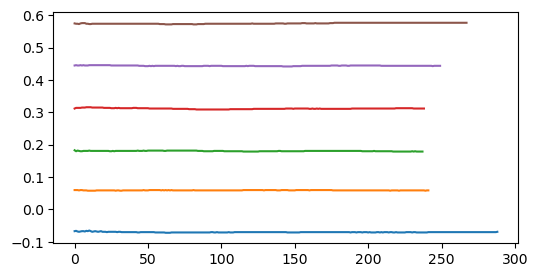

In [294]:
cp   = np.zeros(fn_cstar.shape)
cp_u = np.zeros(fn_cstar.shape)


fig, ax = plt.subplots(1, figsize=[6,3])

for ifn,fn in enumerate(fn_cstar):
    
    if   ('6081' in SN) & ('00' in fn) & ('20250619' in exper):
        cstar = pd.read_csv(fn, sep='\t', usecols=[4], names=['c'], nrows=290)
        
    elif ('6081' in SN) & ('02' in fn) & ('20250624' in exper):
        cstar = pd.read_csv(fn, sep='\t', usecols=[4], names=['c'], nrows=290)
        
    elif ('6081' in SN) & ('02' in fn) & ('20250625' in exper):
        cstar = pd.read_csv(fn, sep='\t', usecols=[4], names=['c'], nrows=290)
    
    else:
        cstar = pd.read_csv(fn, sep='\t', usecols=[4], names=['c'])
    
    cstar.plot(ax=ax, legend=False)
    
    cp[ifn] = np.nanmean(cstar.c)
    cp_u[ifn] = np.nanstd(cstar.c)#/np.sqrt(cstar.c.size)

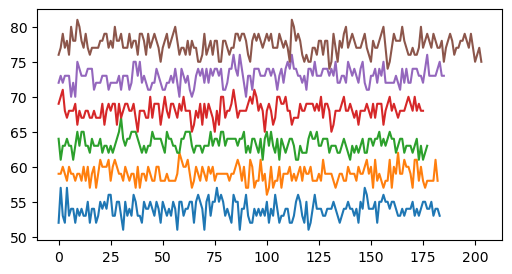

In [295]:
bbp   = np.zeros(fn_bbp.shape)
bbp_u = np.zeros(fn_bbp.shape)


fig, ax = plt.subplots(1, figsize=[6,3])


for ifn,fn in enumerate(fn_bbp):

    if ('6081' in SN) & ('00' in fn) & ('20250619' in exper):
        bb = pd.read_csv(fn, sep='\t', usecols=[5], names=['bb'], nrows=240)
    
    elif ('6081' in SN) & ('00' in fn) & ('20250624' in exper):
        bb = pd.read_csv(fn, sep='\t', usecols=[5], names=['bb'], nrows=240)
    
    else:
        bb = pd.read_csv(fn, sep='\t', usecols=[5], names=['bb'])
    
    bb.plot(ax=ax, legend=False)
    
    bbp[ifn] = np.nanmean(bb.bb)
    bbp_u[ifn] = np.nanstd(bb.bb)#/np.sqrt(bb.bb.size)

In [296]:
cp = cp - cp[0]
cp

array([0.        , 0.1293504 , 0.25069476, 0.3818555 , 0.51416273,
       0.64517416])

In [297]:
bbp

array([53.91847826, 58.93989071, 63.29213483, 68.11363636, 72.93010753,
       77.4754902 ])

In [298]:
# fit
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

linear = odr.Model(f)
mydata = odr.RealData(bbp, cp, sx=bbp_u, sy=cp_u)
p0 = np.polyfit(bbp, cp, 1) # initial values of parameters
myodr = odr.ODR(mydata, linear, beta0=p0)
myoutput = myodr.run()
myoutput.pprint()


rel_res = f(myoutput.beta, bbp[1:]) / cp[1:] -1


Beta: [ 0.0274086  -1.48298372]
Beta Std Error: [0.00020876 0.01372905]
Beta Covariance: [[ 3.15229358e-06 -2.05913064e-04]
 [-2.05913064e-04  1.36342558e-02]]
Residual Variance: 0.01382451325515488
Inverse Condition #: 0.05515132705842289
Reason(s) for Halting:
  Sum of squares convergence


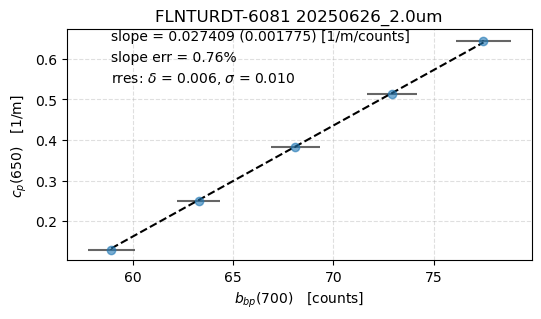

In [299]:
fig, ax = plt.subplots(1,1, figsize=[6,3])

ax.errorbar(bbp[1:], cp[1:], yerr=cp_u[1:], xerr=bbp_u[1:], fmt='o', alpha=0.6, ecolor='k');

ax.plot(bbp[1:], f(myoutput.beta, bbp[1:]), c='k', ls='--')


dY = (cp[-1] - cp[1]) / cp[1:].size / 2
ax.text(bbp[1], cp[-1], f'slope = {myoutput.beta[0]:.6f} ' + f'({myoutput.cov_beta[0][0]**0.5:.6f}) [1/m/counts]')
ax.text(bbp[1], cp[-1]-dY, f'slope err = {100*myoutput.sd_beta[0] /myoutput.beta[0]:.2f}%')
ax.text(bbp[1], cp[-1]-2*dY, rf'rres: $\delta$ = {np.mean(rel_res):.3f}, $\sigma$ = {np.std(rel_res):.3f}')

ax.set_ylabel(r'$c_p$(650)   [1/m]')
ax.set_xlabel(r'$b_{bp}$(700)   [counts]')

ax.set_title(SN + ' ' + exper)

ax.grid(ls='--', alpha=0.4)


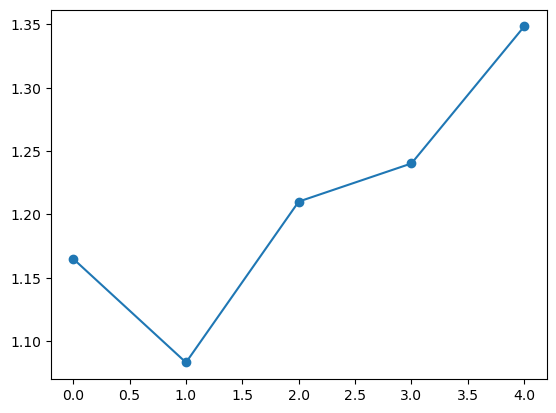

In [300]:
plt.plot(bbp_u[1:], 'o-')